In [278]:
import pandas as pd
import pandasql as ps
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime

### Задание 1

На основе данных из датасета "E-Commerce Data" создайте визуализацию при помощи любого инструмента в свободной форме с расчётами тех метрик, которые являются важными по вашему мнению. Готовую визуализацию загрузите на любой файлообменник, а в поле ответа укажите ссылку.
https://www.kaggle.com/carrie1/ecommerce-data

Описание данных в таблице

1) InvoiceNo - Code representing each unique transaction. If this code starts with letter 'c', it indicates a cancellation.
2) StockCode - Code uniquely assigned to each distinct product.
3) Description - Description of each product.
4) Quantity - The number of units of a product in a transaction.
5) InvoiceDate - The date and time of the transaction.
6) UnitPrice - The unit price of the product in sterling.
7) CustomerID - Identifier uniquely assigned to each customer.
8) Country - The country of the customer.

In [20]:
'''Прочитаем датасет скаченный с Kaggle'''

ecom_data = pd.read_csv('C:\\Users\\kayum\\All_Jupyters\\Тестовое\\Сравни\\data.csv', 
            encoding='unicode_escape')
ecom_data.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom


In [14]:
ecom_data.describe(include='object')

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,541909,541909,540455,541909,541909
unique,25900,4070,4223,23260,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,10/31/2011 14:41,United Kingdom
freq,1114,2313,2369,1114,495478


In [17]:
'''
Мы видим, что у нас в CustomerID очень много пропусков данных,
почти 25% от всех существующих данных.
Удалять их пока не будем. Но нам, возможно, будет важно
знать этот факт для некоторых исследований.
'''

propuski = ecom_data.isnull().sum()
propuski

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

([<matplotlib.patches.Wedge at 0x23cd0a09960>,
 [Text(-0.49355549509975966, -0.9830579704457063, 'Completed'),
  Text(0.49355554112002364, 0.9830579473407053, 'Cancelled')],
 [Text(-0.2692120882362325, -0.5362134384249306, '85.2%'),
  Text(0.26921211333819467, 0.5362134258222028, '14.8%')])

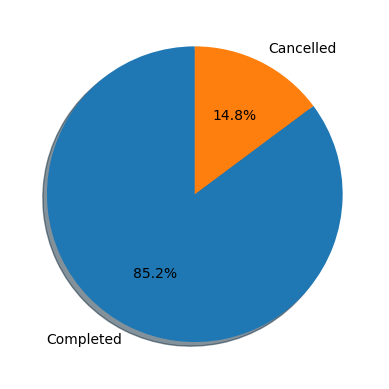

In [74]:
'''
Начем с InvoiceNo. Мы знаем, что буква "С" в начале номера
означет, что транзакция была отменена. Значит осталььные мы считаем завершенными.
Давайте посмотрим соотношение этих показателей
'''

ecom_data['Status'] = np.where(ecom_data['InvoiceNo']
                               .astype(str).str.startswith('C'),
                               'Cancelled', 'Completed')

unique_invoices = ecom_data.drop_duplicates(subset = 'InvoiceNo')
sizes = [len(unique_invoices.query("Status == 'Completed'")), 
         len(unique_invoices.query("Status == 'Cancelled'"))]
labels = ['Completed', 'Cancelled']

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels,  autopct='%1.1f%%',
        shadow=True, startangle=90)

<Axes: xlabel='Quantity', ylabel='StockCode'>

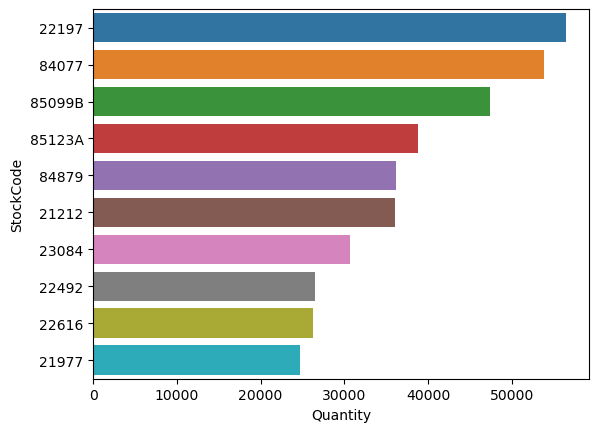

In [119]:
'''
Посмотрим столбец StockCode. 
На его основе мы могли бы узнать количество уникальных товаров.
Мы уже знаем, что у нас 4070 уникальных товаров.
Давайте посмотрим сколько их купили.
Для этого сгруппируем для каждого товара сумму по Quantity.
У нас есть отрицательные значения по Quantity. Это могут быть неправильные записи 
или возвраты, например. Нужны уточнения к данным дополнительные.
Здесь их не будем рассматривать и возьмем только положительные числа.
'''

stocks = ecom_data[['StockCode','Quantity']]
stocks = stocks.groupby('StockCode')['Quantity'].sum().reset_index()\
                .query("Quantity >= 0")\
                .sort_values(by = 'Quantity', ascending = False)

'''Возьмем первые 20 самых продоваемых товаров и посмотрим на их распределение'''

order = [i for i in range(1, len(stocks)+1)]
stocks['order'] = order

sns.barplot(stocks.query("order <= 10"), x="Quantity", y="StockCode")

'''
Продолжая исследование популярных товаров, можно было бы 
также нарисовать круговую диаграмму соотношения 10 самых популярных товаров 
и всех остальных, например. Чтобы выделить товары, которые покупают больше всего.
'''

C:\Users\kayum\AppData\Local\Temp\ipykernel_20412\902385936.py:30: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(tran_per_day['Дата'],


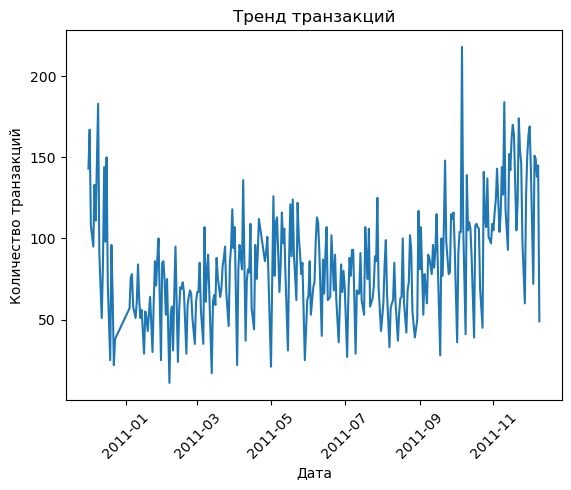

In [199]:
'''
Построим график количества транзакций по дате.
Для этого возьмем уникальные транзакции и датой их совершения.
Затем посчитаем количество транзакций внутри каждой даты и
выведем на линейный график
'''

def to_date(date_string):
    date_format = '%m/%d/%Y %H:%M'
    date_object = datetime.strptime(date_string, date_format)
    date_only = date_object.date()
    return date_only

tran_per_day = ecom_data[['InvoiceNo', 'InvoiceDate']]\
                           .drop_duplicates(subset = 'InvoiceNo')
tran_per_day['InvoiceDate'] = tran_per_day.InvoiceDate.apply(to_date)
tran_per_day = tran_per_day.sort_values(by = 'InvoiceDate')\
                           .groupby('InvoiceDate')['InvoiceNo']\
                           .count().reset_index()\
                           .rename(columns = 
                                   {'InvoiceNo': 'Количество транзакций',
                                    'InvoiceDate': 'Дата'})

'''Эту диаграмму также можно расширять в ходе исследования. 
Например, добавить сразу несколько линий на график по разным товарам, 
чтобы мы могли их сравнивать. Или сгруппировать товары по какому либо признаку
и тоже несколькими линиями отразить тренд по этим признакам.
'''

plt.plot_date(tran_per_day['Дата'], 
              tran_per_day['Количество транзакций'], 
              linestyle='solid', 
              marker=None)
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Количество транзакций')
plt.title('Тренд транзакций')
plt.show()



In [238]:
countrys['Country'][35] == 'United Kingdom'

True

<Axes: xlabel='Country', ylabel='percent'>

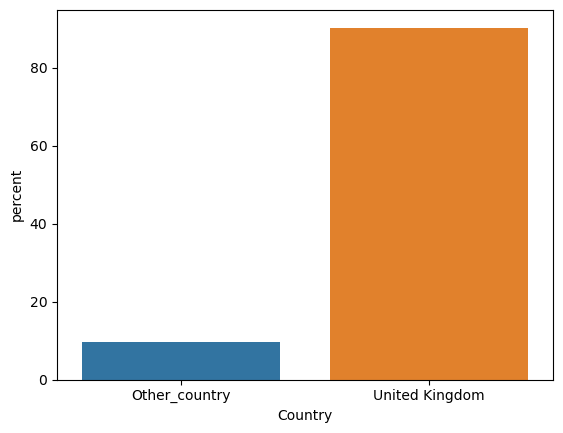

In [273]:
'''
Завершим задачу по визуализации разбивкой CustomerID по странам.
Посмотрим из какой страны у нас больше всего клиентов.
'''

countrys = ecom_data[['CustomerID','Country']]\
                .drop_duplicates(subset = 'CustomerID')
countrys = countrys.groupby('Country')['CustomerID'].count().reset_index()\
                .sort_values(by = 'CustomerID', ascending = False)


# Добавим столбец, определяющий долю клиентов из страны в нашей выгрузке
countrys['percent'] = round(countrys['CustomerID']
                            /countrys['CustomerID'].sum()*100,2)
countrys = countrys.reset_index(drop=True)
countrys

# После добавления процентов видно, что на Англию приходится 90% всех клиентов. 
# Поэтому можно сделать 2 категории. Англия и остальные страны.
     
countrys['Country'] = countrys['Country'].apply(lambda x: 'United Kingdom' 
                                                     if x == 'United Kingdom' 
                                                     else 'Other_country')
countrys = countrys.groupby('Country')['percent'].sum().reset_index()

sns.barplot(data=countrys, x="Country", y="percent")

In [275]:
ecom_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Status
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,Completed
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Completed
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,Completed
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Completed
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Completed
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France,Completed
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France,Completed
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France,Completed
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France,Completed


На основе данных из каггл можно сформировать очень большое количество
метрик. В рамках этого задания захватил лишь небольшую часть. 
Также можно было показать на графиках следующие пункты:
1) Популярность товаров по их описанию
2) Выделить разные ценовые категории, 
посмотреть в каких странах покупают дорогие или дешевые товары. Или какие покупатели чаще совершали транзакции на дорогие товары.
3) Выделить сезонность разных видов товаров. Посмотреть какие товары в какие месяцы лучше всего продаются
4) Посмотреть по каким товаров больше всего отмен транзакций
5) Посмотреть среднее количество товаров внутри транзакций

### Задание 4

Напишите скрипт на Python, получающий данные из HTML таблицы с данными по рождаемости в России (ссылка ниже) и визуализируйте их на графике. Готовый файл в формате .ipynb загрузите на любой файлообменник, а в поле ответа укажите ссылку.
*
https://worldtable.info/gosudarstvo/tablica-rozhdaemosti-po-godam-rossija.html

In [428]:
import requests
from bs4 import BeautifulSoup
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

In [429]:
# Отправляем GET запрос на страницу
url = 'https://worldtable.info/gosudarstvo/tablica-rozhdaemosti-po-godam-rossija.html'
response = requests.get(url, verify=False)

# Создаем объект BeautifulSoup для парсинга HTML
soup = BeautifulSoup(response.text, 'html.parser')

# Находим таблицу на странице
table = soup.find('tbody')

In [436]:
'''
В таблице две колонки. В четных записаны года, в нечетных количество родившихся.
Создаем переменные по нужно нам длине начиная с 2, чтобы не захватывать шапку таблицы,
которую создадим потом сами в скрипте
'''

years_cell_number = [i for i in range(2,len(table.find_all('td'))) if i%2==0]
born_cell_number = [i for i in range(2,len(table.find_all('td'))) if i%2!=0]

'''
Создадим переменные Year и Number_of_people_born, 
куда запишем все данные с таблицы на сайте
'''

Year = []
for i in years_cell_number:
    Year.append(table.find_all('td')[i].get_text())

Number_of_people_born = []
for i in born_cell_number:
    Number_of_people_born.append(table.find_all('td')[i].get_text())

# Конвертируем количество в числовой формат    
Number_of_people_born_int = []    
for i in Number_of_people_born:
    Number_of_people_born_int.append(int(i.replace(' ','')))
    
# Создаем датафрейм на основе наших переменных.
df = pd.DataFrame({'Год': Year, 'Количество родившихся чел.': Number_of_people_born_int})
df.head(3)

,Год,Количество родившихся чел.
0,1959,2796228
1,1960,2782353
2,1961,2662135


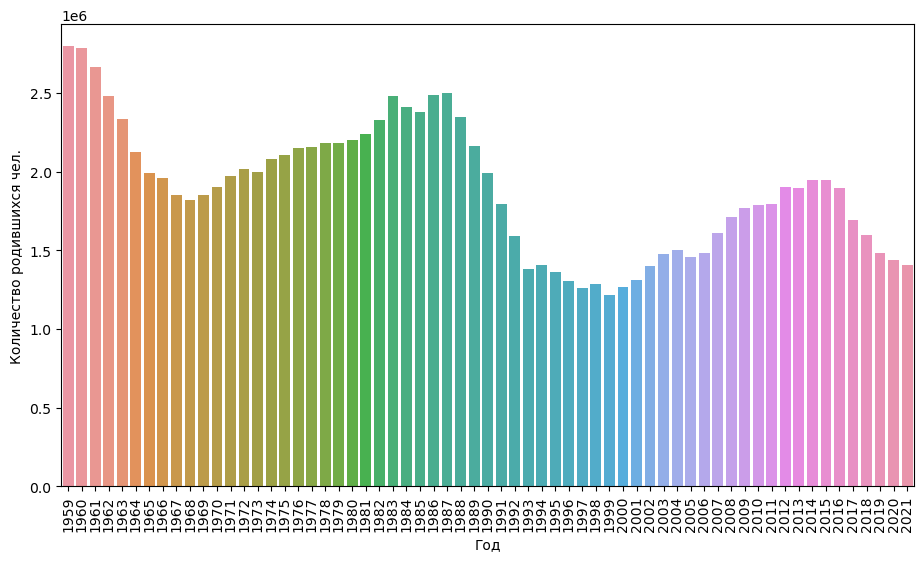

In [458]:
plt.figure(figsize=(11, 6))
ax = sns.barplot(data=df, x="Год", y="Количество родившихся чел.")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()